# <div style="text-align: right"> Chapter __18__</div>

# __Model basics with modelr__

## Introduction
The goal of a model is to provide a simple low-dimensional sum‐
mary of a dataset. In the context of this book we’re going to use
models to partition data into patterns and residuals. Strong patterns
will hide subtler trends, so we’ll use models to help peel back layers
of structure as we explore a dataset.

There are two parts to a model:

1. First, you define a family of models that express a precise, but
generic, pattern that you want to capture. For example, the pat‐
tern might be a straight line, or a quadatric curve. You will
express the model family as an equation like `y = a_1 * x + a_2` or
`y = a_1 * x ^ a_2` . Here, `x` and `y` are known variables
from your data, and `a_1` and `a_2` are parameters that can vary to
capture different patterns.

2. Next, you generate a fitted model by finding the model from the
family that is the closest to your data. This takes the generic
model family and makes it specific, like `y = 3 * x + 7` or
`y = 9 * x ^ 2 `.

It’s important to understand that a fitted model is just the closest
model from a family of models. That implies that you have the
“best” model (according to some criteria); it doesn’t imply that you
have a good model and it certainly doesn’t imply that the model is
“true.” George Box puts this well in his famous aphorism:

`All models are wrong, but some are useful.`

It’s worth reading the fuller context of the quote:
Now it would be very remarkable if any system existing in the real
world could be exactly represented by any simple model. However,
cunningly chosen parsimonious models often do provide remarka‐
bly useful approximations. For example, the law PV = RT relating
pressure P, volume V and temperature T of an “ideal” gas via a con‐
stant R is not exactly true for any real gas, but it frequently provides
a useful approximation and furthermore its structure is informative
since it springs from a physical view of the behavior of gas mole‐
cules.
For such a model there is no need to ask the question “Is the model
true?” If “truth” is to be the “whole truth” the answer must be “No.”
The only question of interest is “Is the model illuminating and use‐
ful?""

`The goal of a model is not to uncover truth, but to discover a simple
approximation that is still useful.`

In [1]:
# config
repr_html.tbl_df <- function(obj, ..., rows = 6) repr:::repr_html.data.frame(obj, ..., rows = rows)
options(dplyr.summarise.inform = FALSE)

In [4]:
library(tidyverse)
library(modelr)
options(na.action = na.warn)

### A simple model
Let’s take a look at the simulated dataset `sim1` . It contains two continuous variables,` x` and `y` . Let’s plot them to see how they’re related:

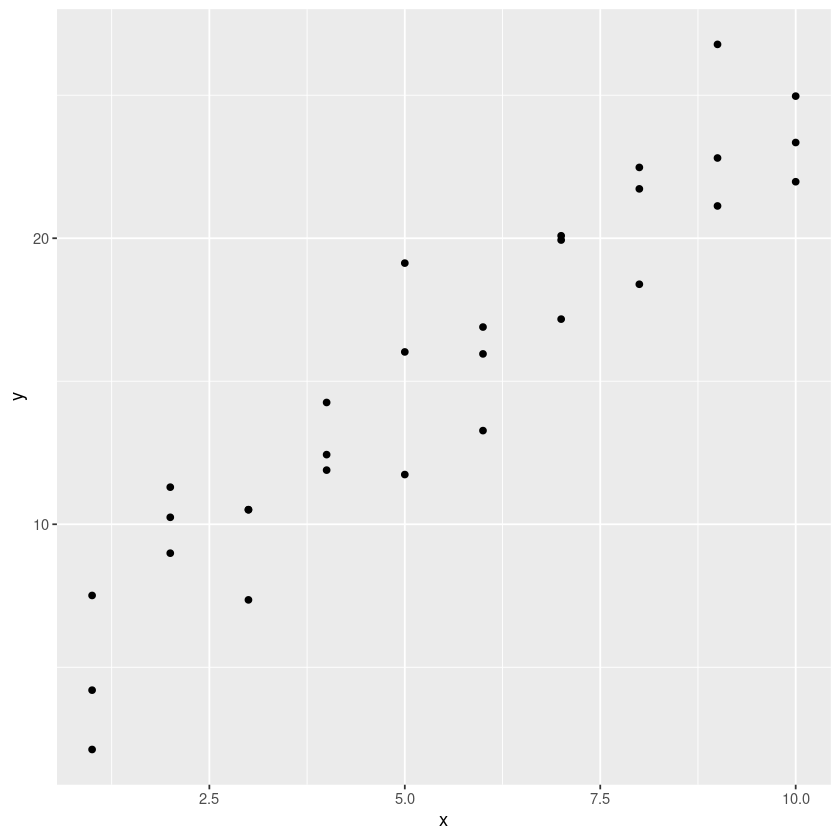

In [5]:
ggplot(sim1, aes(x, y)) +
    geom_point()

You can see a strong pattern in the data. Let’s use a model to capture
that pattern and make it explicit. It’s our job to supply the basic form
of the model. In this case, the relationship looks linear, i.e.,
`y = a_0 + a_1 * x` . Let’s start by getting a feel for what models from that
family look like by randomly generating a few and overlaying them
on the data. For this simple case, we can use `geom_abline()` , which
takes a slope and intercept as parameters. Later on we’ll learn more
general techniques that work with any model:

In [6]:
models <- tibble(
    a1 = runif(250, -20, 40),
    a2 = runif(250, -5, 5)
)

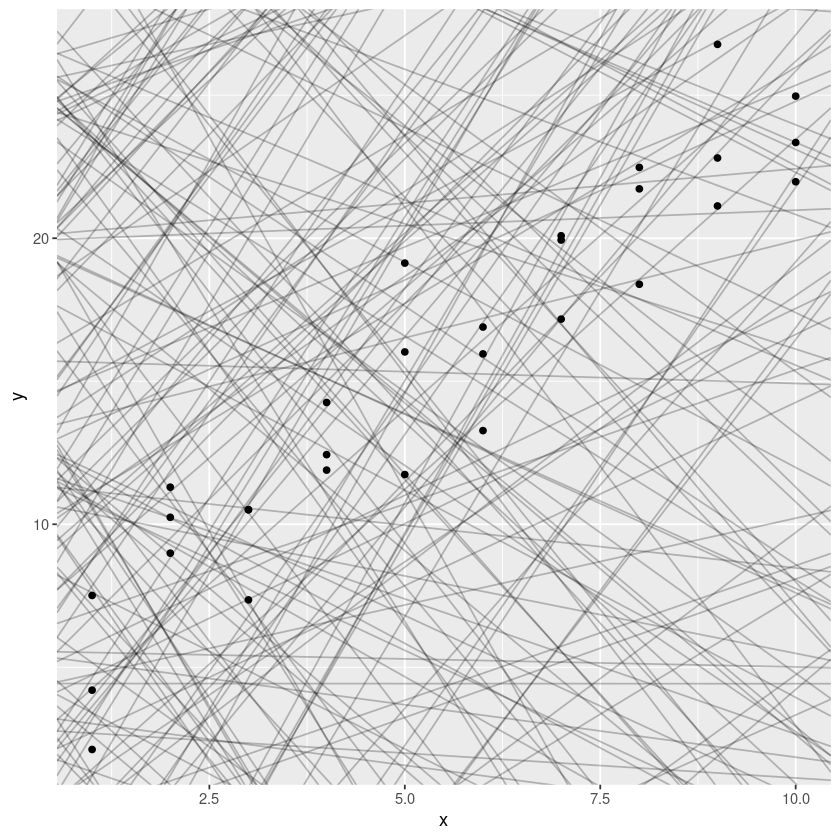

In [8]:
ggplot(sim1, aes(x, y)) +
    geom_abline(aes(intercept = a1, slope = a2),
                data = models, alpha = 1/4) +
    geom_point()

There are 250 models on this plot, but a lot are really bad! We need
to find the good models by making precise our intuition that a good
model is “close” to the data. We need a way to quantify the distance
between the data and a model. Then we can fit the model by finding
the values of `a_0` and `a_1` that generate the model with the smallest
distance from this data.
One easy place to start is to find the vertical distance between each
point and the model.
This distance is just the difference between the y value given by the
model (the prediction), and the actual y value in the data (the
response).
To compute this distance, we first turn our model family into an R
function. This takes the model parameters and the data as inputs,
and gives values predicted by the model as output

In [9]:
model1 <- function(a, data) {
    a[1] + data$x * a[2]
}
model1(c(7, 1.5), sim1)

[1]  8.5  8.5  8.5 10.0 10.0 10.0 11.5 11.5 11.5 13.0 13.0 13.0 14.5 14.5 14.5
[16] 16.0 16.0 16.0 17.5 17.5 17.5 19.0 19.0 19.0 20.5 20.5 20.5 22.0 22.0 22.0

Next, we need some way to compute an overall distance between the
predicted and actual values. In other words, the plot shows 30 distances: how do we collapse that into a single number?

One common way to do this in statistics is to use the “root-mean squared deviation.” We compute the difference between actual and
predicted, square them, average them, and then take the square root.

In [11]:
measure_distance <- function(mod, data) {
    diff <- data$y - model1(mod, data)
    sqrt(mean(diff ^ 2))
}

In [12]:
measure_distance(c(7, 1.5), sim1)

[1] 2.665212

Now we can use __purrr__ to compute the distance for all the models
defined previously. We need a helper function because our distance
function expects the model as a numeric vector of length 2:

In [13]:
sim1_dist <- function(a1, a2) {
    measure_distance(c(a1, a2), sim1)
}

In [14]:
models <- models %>%
    mutate(dist = map2_dbl(a1, a2, sim1_dist))

In [15]:
models

a1,a2,dist
<dbl>,<dbl>,<dbl>
-1.827313,4.4406069,10.095082
4.146215,0.6067371,9.278292
18.126188,4.4746839,28.188474
⋮,⋮,⋮
-19.161788,2.338494,21.92343
25.100254,-1.704013,10.99720
-8.886194,1.221854,17.95678


Next, let’s overlay the 10 best models on to the data. I’ve colored the
models by `-dist` : this is an easy way to make sure that the best models (i.e., the ones with the smallest distance) get the brighest colors:

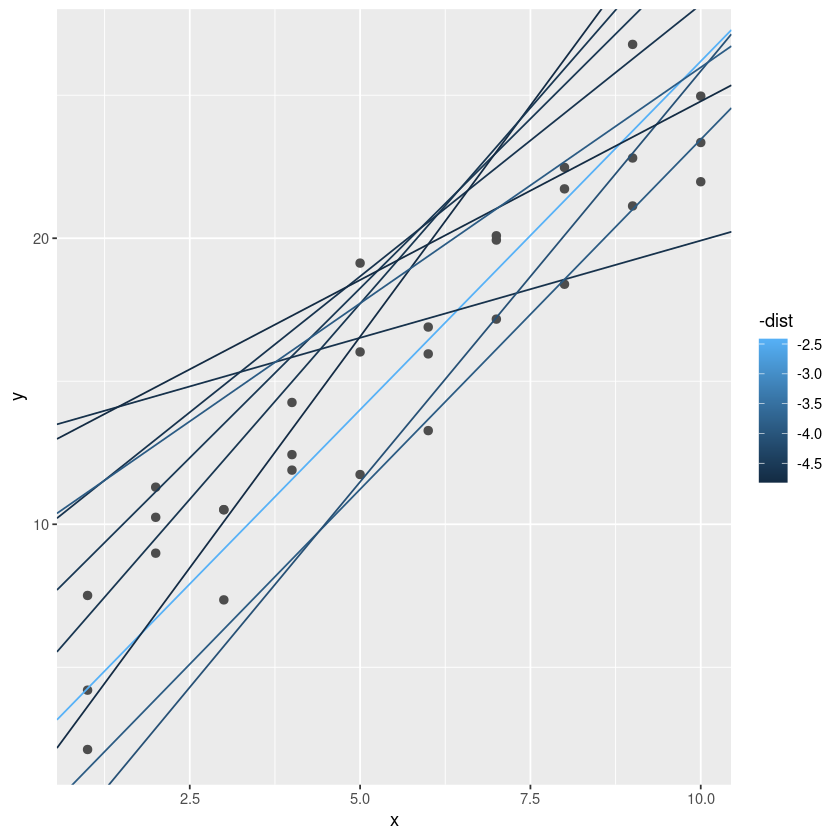

In [16]:
ggplot(sim1, aes(x, y)) +
    geom_point(size = 2, color = 'grey30') +
    geom_abline(aes(intercept = a1, slope = a2, color = -dist),
                data = filter(models, rank(dist) <= 10))

We can also think about these models as observations, and visualize
them with a scatterplot of `a1` versus `2` , again colored by -dist . We
can no longer directly see how the model compares to the data, but
we can see many models at once. Again, I’ve highlighted the 10 best
models, this time by drawing red circles underneath them:

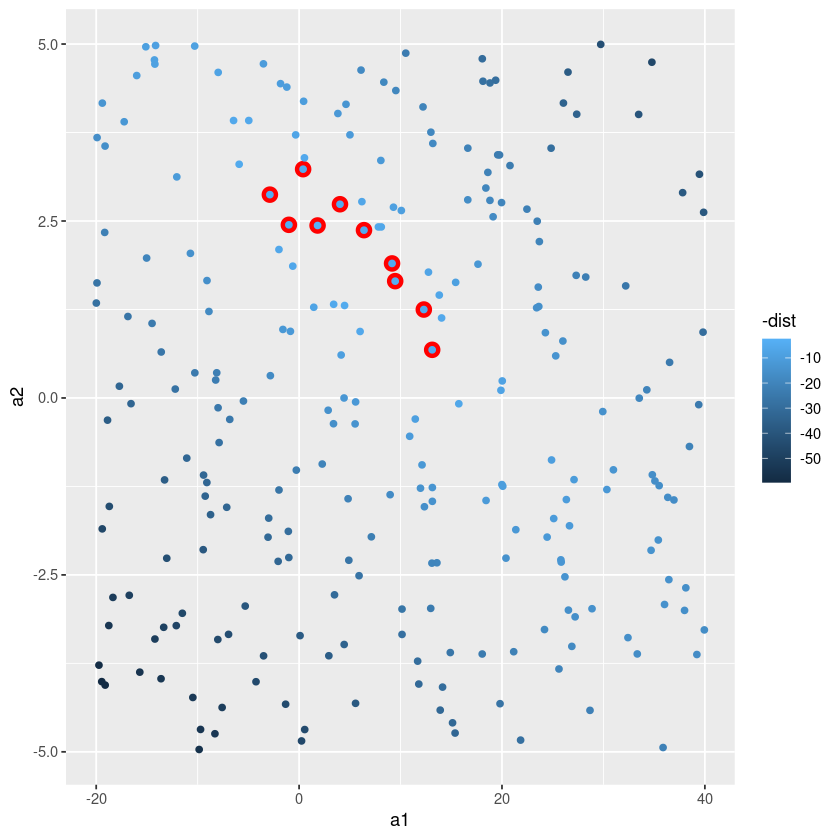

In [17]:
ggplot(models, aes(a1, a2)) +
    geom_point(data = filter(models, rank(dist) <= 10),
               size = 4,
               color = 'red') +
    geom_point(aes(color = -dist))

Instead of trying lots of random models, we could be more system‐
atic and generate an evenly spaced grid of points (this is called a grid
search). I picked the parameters of the grid roughly by looking at
where the best models were in the preceding plot:

In [18]:
grid <- expand.grid(
    a1 = seq(-5, 20, length = 25),
    a2 = seq(1, 3, length = 25)
) %>%
    mutate(dist = map2_dbl(a1, a2, sim1_dist))

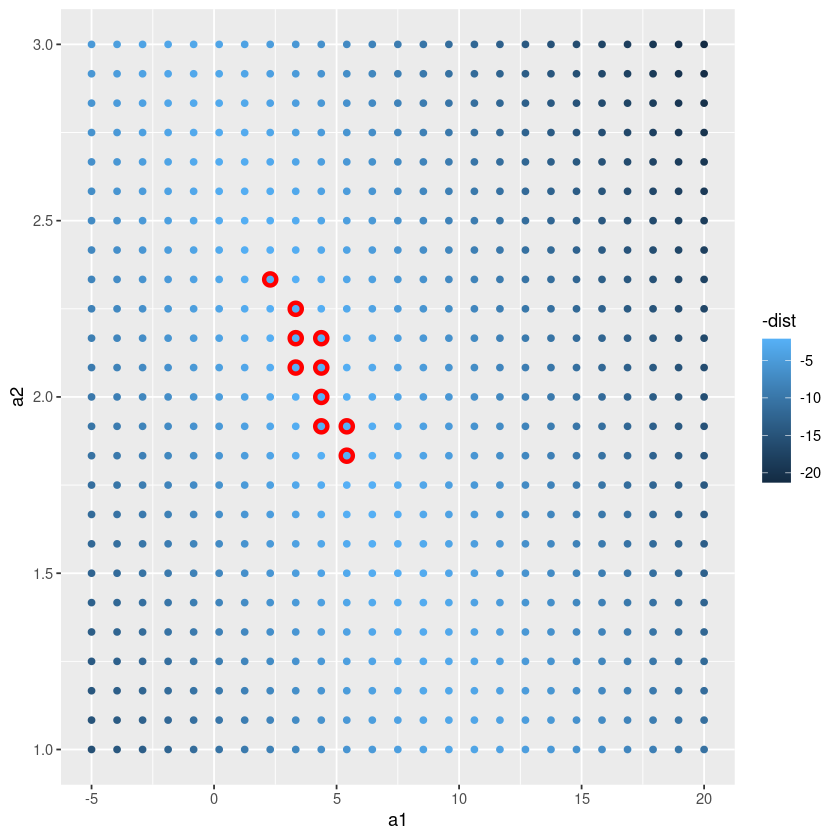

In [19]:
grid %>%
    ggplot(aes(a1, a2)) +
    geom_point(data = filter(grid, rank(dist) <= 10),
               size = 4,
               color = 'red') +
    geom_point(aes(color = -dist))

When you overlay the best 10 models back on the original data, they
all look pretty good:

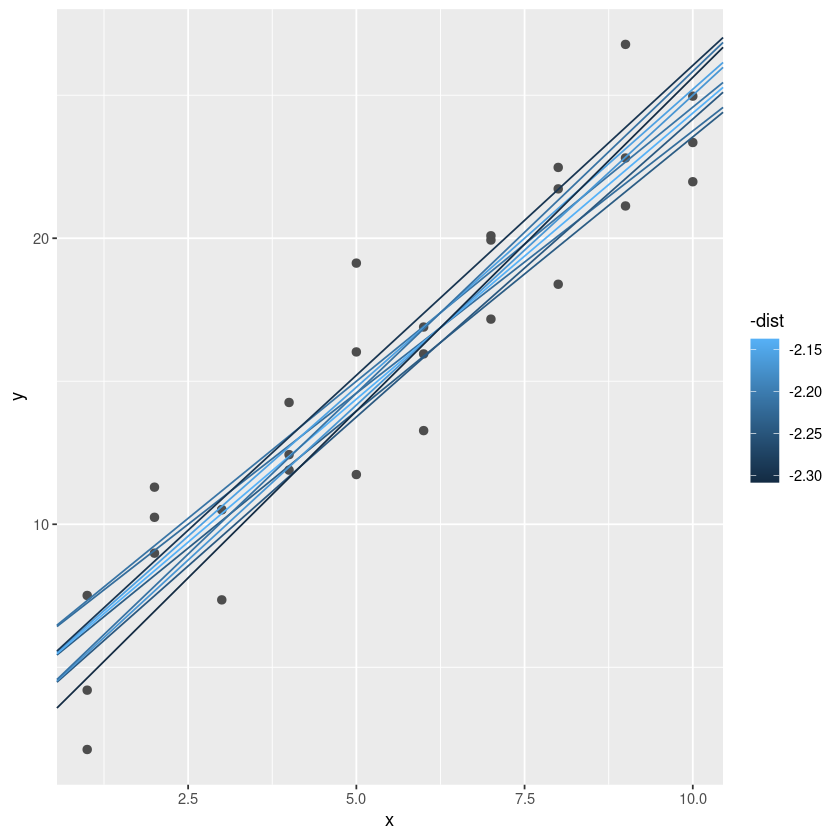

In [21]:
ggplot(sim1, aes(x, y)) +
    geom_point(size = 2,
               color = 'grey30') +
    geom_abline(aes(intercept = a1,
                    slope = a2,
                    color = -dist),
                data = filter(grid, rank(dist) <= 10))

You could imagine iteratively making the grid finer and finer until
you narrowed in on the best model. But there’s a better way to tackle
that problem: a numerical minimization tool called Newton–Raph‐
son search. The intuition of Newton–Raphson is pretty simple: you
pick a starting point and look around for the steepest slope. You
then ski down that slope a little way, and then repeat again and
again, until you can’t go any lower. In R, we can do that with
`optim()` :

In [24]:
best <- optim(c(0, 0), measure_distance, data = sim1)
best$par

[1] 4.222248 2.051204

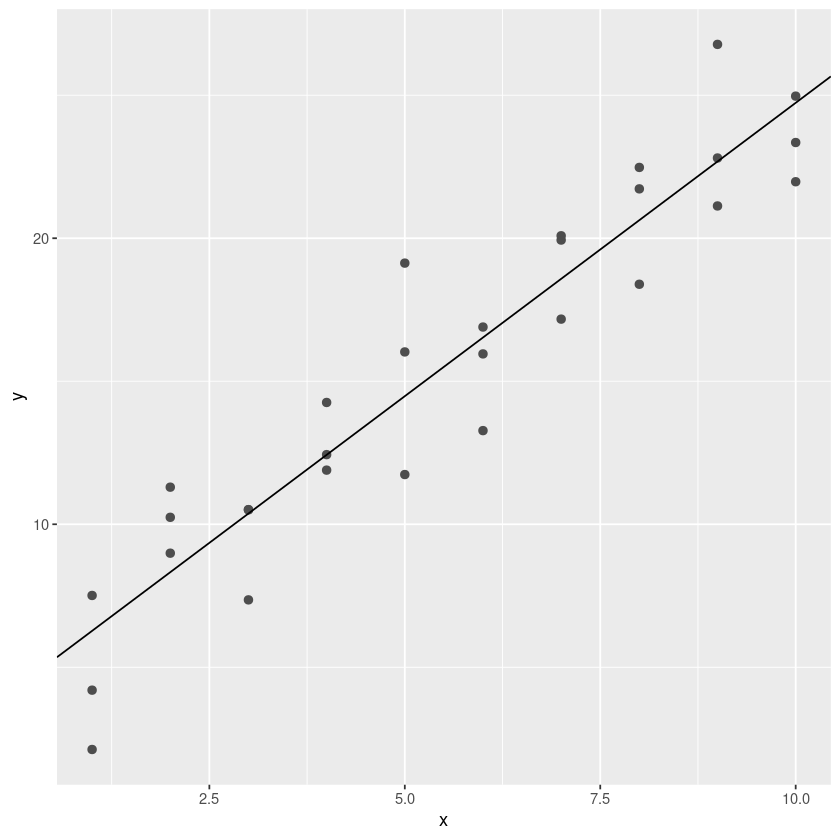

In [25]:
ggplot(sim1, aes(x, y)) +
    geom_point(size = 2,
               color = 'grey30') +
    geom_abline(intercept = best$par[1],
                slope = best$par[2])

Don’t worry too much about the details of how `optim()` works. It’s
the intuition that’s important here. If you have a function that
defines the distance between a model and a dataset, and an algorithm that can minimize that distance by modifying the parameters
of the model, you can find the best model. The neat thing about this
approach is that it will work for any family of models that you can
write an equation for.

There’s one more approach that we can use for this model, because it
is a special case of a broader family: linear models. A linear model
has the general form
`y = a_1 + a_2 * x_1 + a_3 * x_2 + ... + a_n * x_(n - 1)` .
So this simple model is equivalent to a general
linear model where `n` is `2` and `x_1` i `x` . R has a tool specifically
designed for fitting linear models called `lm()` . `lm()` has a special way
to specify the model family: formulas. Formulas look like `y ~ x` ,
which `lm()` will translate to a function like `y = a_1 + a_2 * x` . We
can fit the model and look at the output:

In [26]:
sim1_mod <- lm(y ~ x, data = sim1)
coef(sim1_mod)

(Intercept)           x 
   4.220822    2.051533

These are exactly the same values we got with `optim()` ! Behind the
scenes `lm()` doesn’t use `optim()` but instead takes advantage of the
mathematical structure of linear models. Using some connections
between geometry, calculus, and linear algebra, `lm()` actually finds
the closest model in a single step, using a sophisticated algorithm.
This approach is faster and guarantees that there is a global minimum.

### __Excercises__

1. __One downside of the linear model is that it is sensitive to
unusual values because the distance incorporates a squared
term. Fit a linear model to the following simulated data, and vis‐
ualize the results. Rerun a few times to generate different simu‐
lated datasets. What do you notice about the model?__measure_distance <- function(mod, data) {
  diff <- data$y - make_prediction(mod, data)
  mean(abs(diff))
}

In [28]:
sim1a <- tibble(
  x = rep(1:10, each = 3),
  y = x * 1.5 + 6 + rt(length(x), df = 2)
)

Lets run it once and plot the results

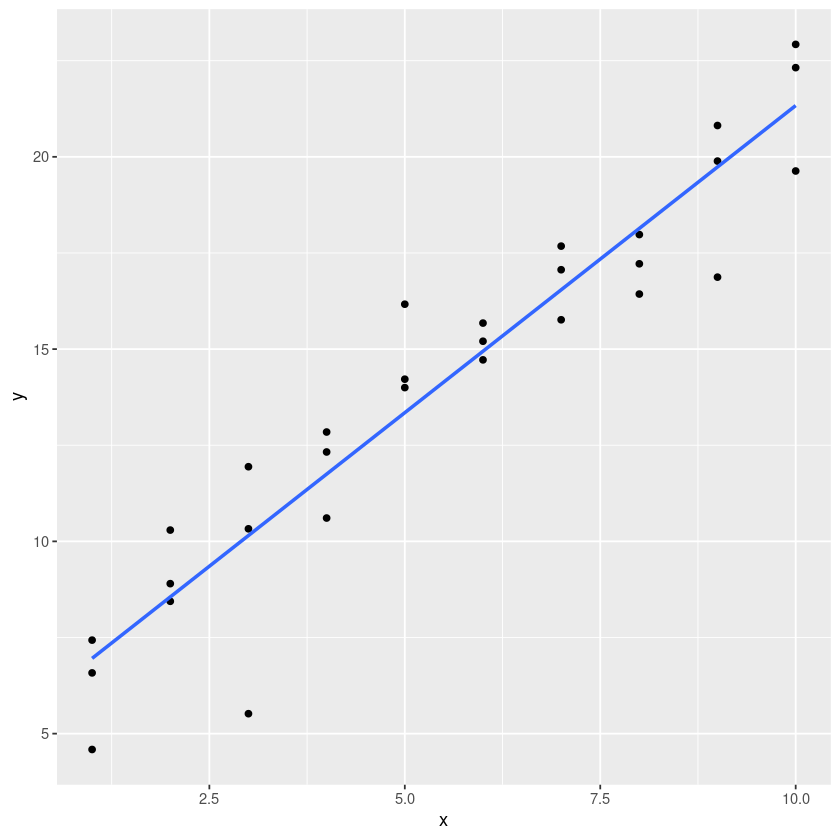

In [31]:
ggplot(sim1a, aes(x = x, y = y)) +
  geom_point() +
  geom_smooth(method = "lm",
              se = FALSE,
              formula = y ~ x)

 We can also do this more systematically, by generating several simulations and plotting the line.

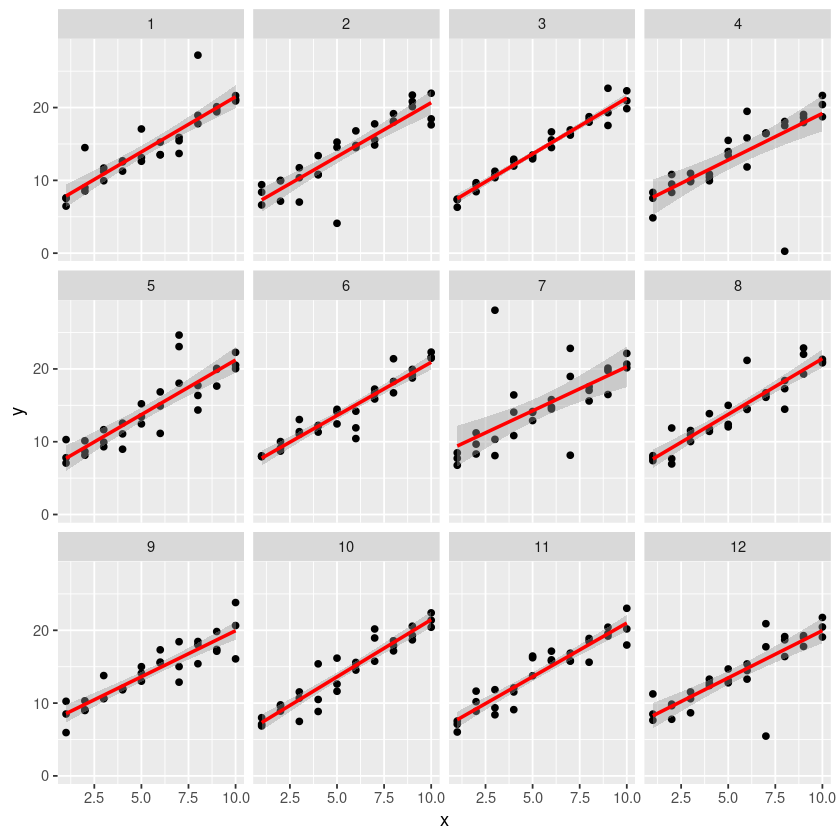

In [32]:
simt <- function(i) {
  tibble(
    x = rep(1:10, each = 3),
    y = x * 1.5 + 6 + rt(length(x), df = 2),
    .id = i
  )
}

sims <- map_df(1:12, simt)

ggplot(sims, aes(x = x, y = y)) +
  geom_point() +
  geom_smooth(method = "lm",
              colour = "red",
              formula = y ~ x) +
  facet_wrap(~.id, ncol = 4)

What if we did the same things with normal distributions?

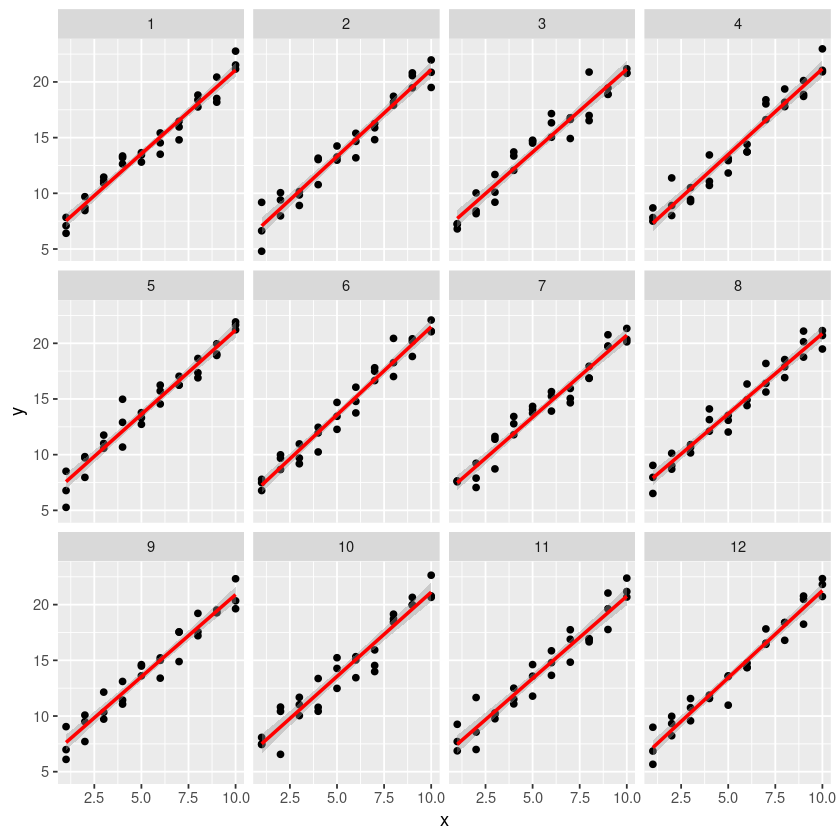

In [33]:
sim_norm <- function(i) {
  tibble(
    x = rep(1:10, each = 3),
    y = x * 1.5 + 6 + rnorm(length(x)),
    .id = i
  )
}

simdf_norm <- map_df(1:12, sim_norm)

ggplot(simdf_norm, aes(x = x, y = y)) +
  geom_point() +
  geom_smooth(method = "lm", colour = "red",
              formula = y ~ x) +
  facet_wrap(~.id, ncol = 4)

There are not large outliers, and the slopes are more similar.

The reason for this is that the Student’s t
-distribution, from which we sample with `rt()` has heavier tails than the normal distribution (`rnorm()`). This means that the Student’s t-distribution assigns a larger probability to values further from the center of the distribution.

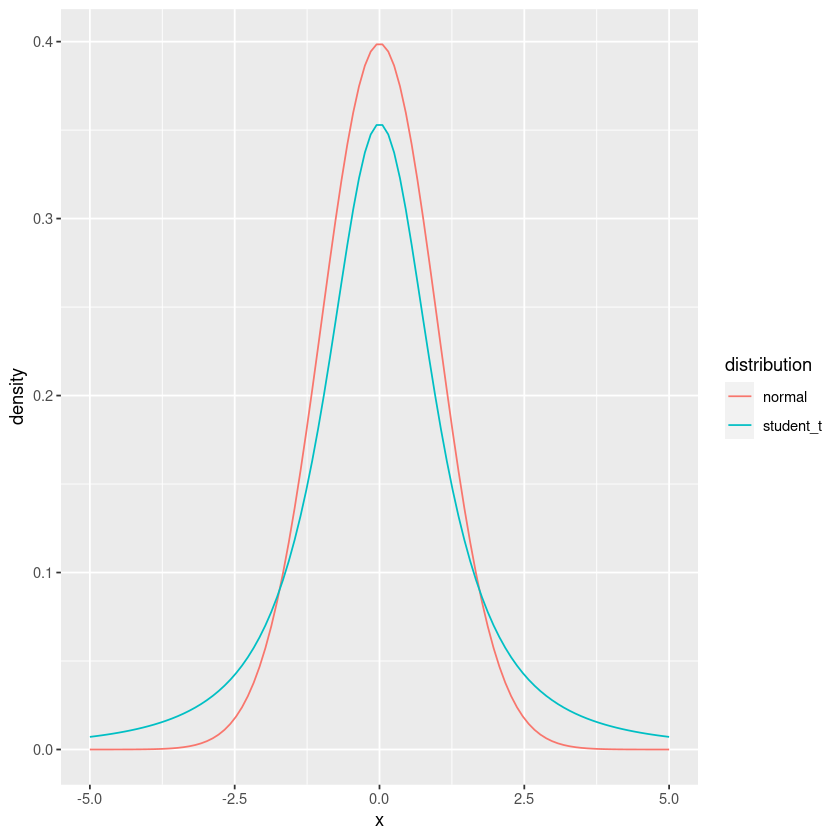

In [34]:
tibble(
  x = seq(-5, 5, length.out = 100),
  normal = dnorm(x),
  student_t = dt(x, df = 2)
) %>%
  pivot_longer(-x, names_to="distribution", values_to="density") %>%
  ggplot(aes(x = x, y = density, colour = distribution)) +
  geom_line()

For a normal distribution with mean zero and standard deviation one, the probability of being greater than 2 is,

In [35]:
pnorm(2, lower.tail = FALSE)

[1] 0.02275013

For a Student’s t distribution with degrees of freedom = 2, it is more than 3 times higher,

In [36]:
pt(2, df = 2, lower.tail = FALSE)

[1] 0.09175171

2. __One way to make linear models more robust is to use a different
distance measure. For example, instead of root-mean-squared
distance, you could use mean-absolute distance:__

In [37]:
measure_distance <- function(mod, data) {
  diff <- data$y - make_prediction(mod, data)
  mean(abs(diff))
}

For the above function to work, we need to define a function, `make_prediction()`, that takes a numeric vector of length two (the intercept and slope) and returns the predictions,

In [38]:
make_prediction <- function(mod, data) {
  mod[1] + mod[2] * data$x
}

Using the `sim1a` data, the best parameters of the least absolute deviation are:

In [39]:
best <- optim(c(0, 0), measure_distance, data = sim1a)
best$par

[1] 5.748502 1.576064

Using the `sim1a` data, while the parameters the minimize the least squares objective function are:

In [40]:
measure_distance_ls <- function(mod, data) {
  diff <- data$y - (mod[1] + mod[2] * data$x)
  sqrt(mean(diff^2))
}

best <- optim(c(0, 0), measure_distance_ls, data = sim1a)
best$par

[1] 5.359918 1.597366

3. __One challenge with performing numerical optimization is that
it’s only guaranteed to find one local optima. What’s the problem with optimizing a three-parameter model like this?__

In [44]:
model3 <- function(a, data) {
    a[1] + data$x * a[2] + a[3]
}

The problem is that you for any values `a[1] = a1` and `a[3] = a3`, any other values of `a[1]` and `a[3]` where `a[1] + a[3] == (a1 + a3)` will have the same fit.

In [45]:
measure_distance_3 <- function(a, data) {
  diff <- data$y - model3(a, data)
  sqrt(mean(diff^2))
}

Depending on our starting points, we can find different optimal values:

In [46]:
best3a <- optim(c(0, 0, 0), measure_distance_3, data = sim1)
best3a$par

[1] 3.3672228 2.0515737 0.8528513

In [47]:
best3b <- optim(c(0, 0, 1), measure_distance_3, data = sim1)
best3b$par

[1] -3.469885  2.051509  7.690289

In [48]:
best3c <- optim(c(0, 0, 5), measure_distance_3, data = sim1)
best3c$par

[1] -1.124446  2.051520  5.345616

## __Visualizing Models__

For simple models, like the one in the previous section, you can fig‐
ure out what pattern the model captures by carefully studying the
model family and the fitted coefficients. And if you ever take a sta‐
tistics course on modeling, you’re likely to spend a lot of time doing
just that. Here, however, we’re going to take a different tack. We’re
going to focus on understanding a model by looking at its predic‐
tions. This has a big advantage: every type of predictive model
makes predictions (otherwise what use would it be?) so we can use
the same set of techniques to understand any type of predictive
model.

It’s also useful to see what the model doesn’t capture, the so-called
residuals that are left after subtracting the predictions from the data.
Residuals are powerful because they allow us to use models to
remove striking patterns so we can study the subtler trends that
remain.

### Predictions

To visualize the predictions from a model, we start by generating an
evenly spaced grid of values that covers the region where our data
lies. The easiest way to do that is to use `modelr::data_grid()` . Its
first argument is a data frame, and for each subsequent argument it
finds the unique variables and then generates all combinations:

In [50]:
grid <- sim1 %>%
    data_grid(x)

In [51]:
grid

x
<int>
1
2
3
⋮
8
9
10


(This will get more interesting when we start to add more variables
to our model.)
Next we add predictions. We’ll use `modelr::add_predictions()` ,
which takes a data frame and a model. It adds the predictions from
the model to a new column in the data frame:

In [52]:
grid <- grid %>%
    add_predictions(sim1_mod)

In [53]:
grid

x,pred
<int>,<dbl>
1,6.272355
2,8.323888
3,10.375421
⋮,⋮
8,20.63309
9,22.68462
10,24.73615


Next, we plot the predictions. You might wonder about all this extra
work compared to just using `geom_abline() `. But the advantage of
this approach is that it will work with any model in R, from the sim‐
plest to the most complex. You’re only limited by your visualization
skills.

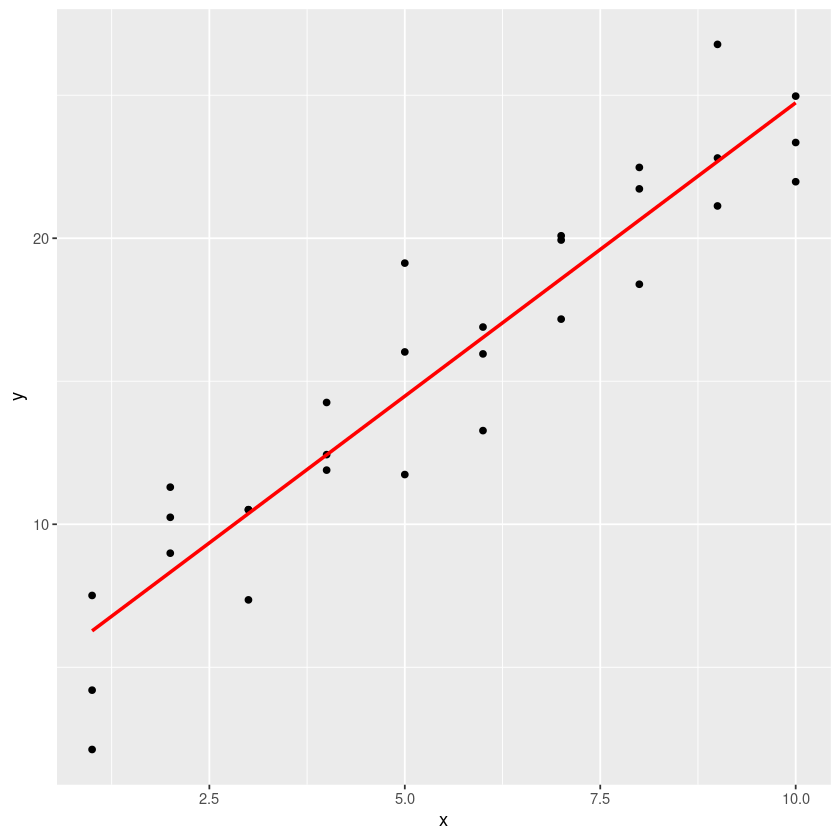

In [54]:
ggplot(sim1, aes(x)) +
    geom_point(aes(y = y)) +
    geom_line(aes(y = pred),
              data = grid,
              color = 'red',
              size = 1)

### Residuals

The flip side of predictions are residuals. The predictions tell you the
pattern that the model has captured, and the residuals tell you what
the model has missed. The residuals are just the distances between
the observed and predicted values that we computed earlier.

We add residuals to the data with `add_residuals()` , which works
much like `add_predictions()` . Note, however, that we use the original dataset, not a manufactured grid. This is because to compute
residuals we need actual y values:

In [55]:
sim1 <- sim1 %>%
    add_residuals(sim1_mod)

In [56]:
sim1

x,y,resid
<int>,<dbl>,<dbl>
1,4.199913,-2.072442
1,7.510634,1.238279
1,2.125473,-4.146882
⋮,⋮,⋮
10,24.96810,0.2319467
10,23.34642,-1.3897306
10,21.97520,-2.7609520


There are a few different ways to understand what the residuals tell
us about the model. One way is to simply draw a frequency polygon
to help us understand the spread of the residuals:

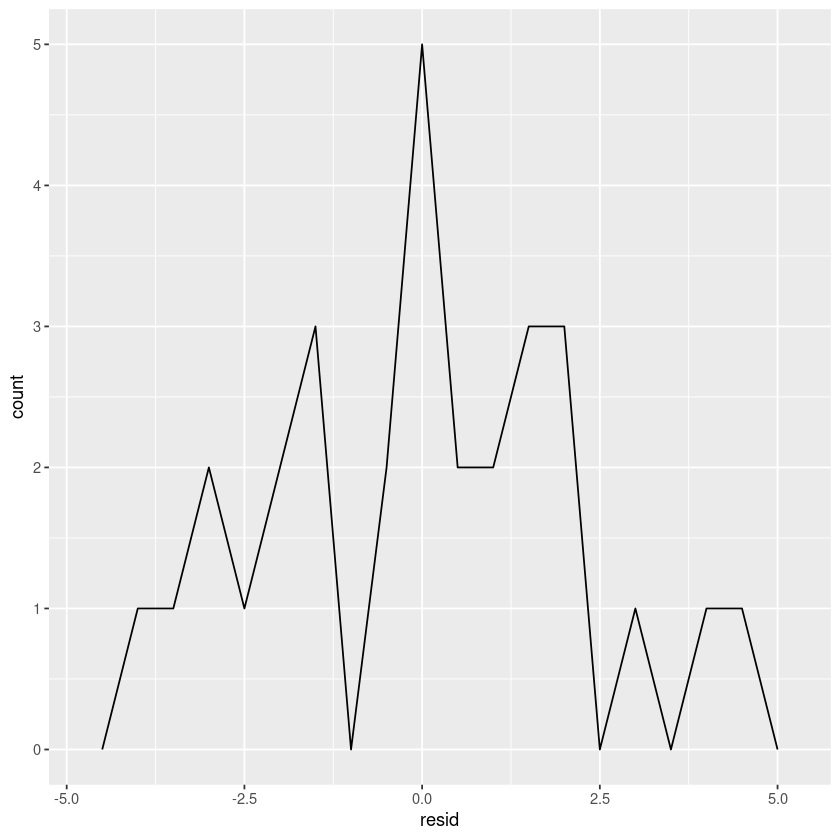

In [57]:
ggplot(sim1, aes(resid)) +
    geom_freqpoly(binwidth = 0.5)

This helps you calibrate the quality of the model: how far away are
the predictions from the observed values? Note that the average of
the residual will always be 0.

You’ll often want to re-create plots using the residuals instead of the
original predictor. You’ll see a lot of that in the next chapter:

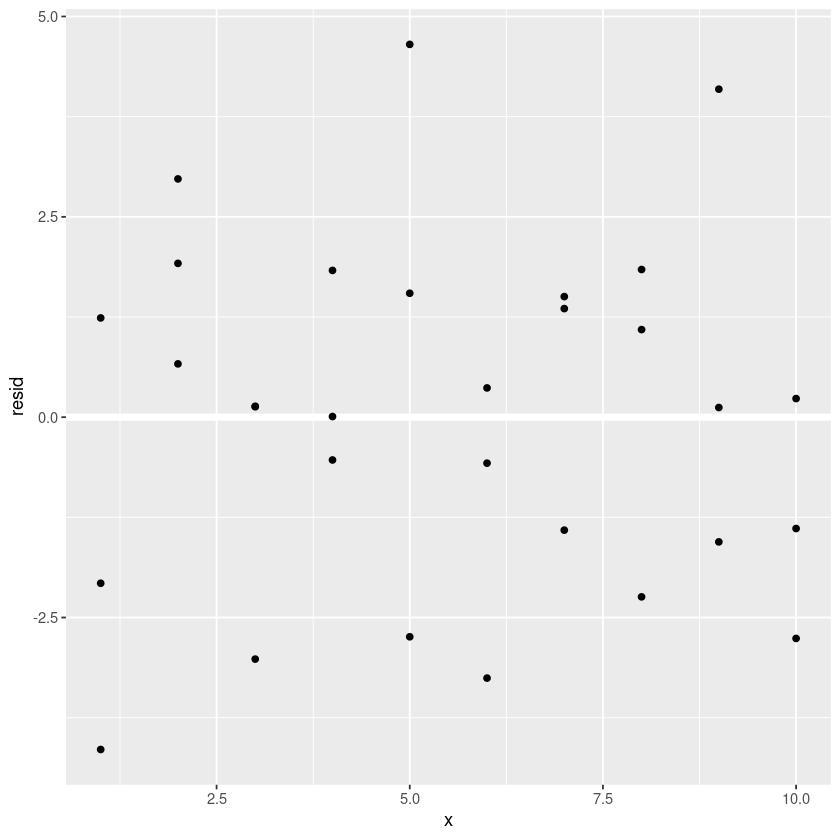

In [58]:
ggplot(sim1, aes(x, resid)) +
    geom_ref_line(h = 0) +
    geom_point()

This looks like random noise, suggesting that our model has done a
good job of capturing the patterns in the dataset.